In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch # Libreria
from torch.utils.data import Dataset # Clase u objeto que va a contener la informacion que vamos a utilizar para entrenar y evaluar nuestro algoritmo
from torch.utils.data import DataLoader

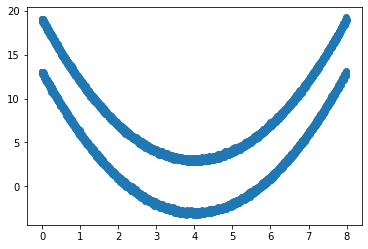

In [2]:
w = np.random.uniform(0, 8, 10000)
u = np.random.uniform(0, 1, 10000)
n1 = np.random.normal(3, 0.1, 10000)
n2 = np.random.normal(-3, 0.1, 10000)
z = (w-4)**2
z[u >= 0.5] = z[u >= 0.5] + n1[u >= 0.5]
z[u < 0.5] = z[u < 0.5] + n2[u <= 0.5]
fig, ax = plt.subplots(1,1)
ax.scatter(w, z)

In [3]:
l = np.zeros(10000)
mask = z >= (w-4)**2
l[mask] = 1
l[~mask] = 0

idx = np.random.permutation(np.arange(0, 10000))
w_train = w[idx[0:int(0.8*10000)]]
w_test = w[idx[int(0.8*10000):]]

z_train = z[idx[0:int(0.8*10000)]]
z_test = z[idx[int(0.8*10000):]]

l_train = l[idx[0:int(0.8*10000)]]
l_test = l[idx[int(0.8*10000):]]

x_train = np.zeros((w_train.shape[0],2))
x_train[:,0] = w_train
x_train[:,1] = z_train

x_test = np.zeros((w_test.shape[0],2))
x_test[:,0] = w_test
x_test[:,1] = z_test

print(w_train.shape)
print(w_test.shape)
print(z_train.shape)
print(z_test.shape)
print(x_train.shape)
print(x_test.shape)

(8000,)
(2000,)
(8000,)
(2000,)
(8000, 2)
(2000, 2)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
  
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]


In [5]:
training_set = CustomDataset(x_train, l_train)

In [6]:
len(training_set) #sobrecarga del operador 'len()'

8000

In [7]:
training_set.__len__()

8000

In [8]:
training_set[0] # sobrecarga de operador '[]'

(array([ 5.59511736, -0.45669661]), 0.0)

In [9]:
training_set.__getitem__(0)

(array([ 5.59511736, -0.45669661]), 0.0)

In [10]:
test_set = CustomDataset(x_test, l_test)

In [11]:
training_dataloader = DataLoader(training_set, batch_size = 512, shuffle=True)
# El data loader simpre espera el set de datos, el batch_size que 
# preferentemente deberia ser potencia de 2 para optimizar los calculos,
# y opcional el shuffel que mezcla los datos cada vez que comienza una epoch
test_dataloader = DataLoader(test_set, batch_size = 256, shuffle=True)

In [12]:
len(training_dataloader) # Muestra el tamaño de cada batch

16

In [13]:
x_train.shape[0]/512 # batch_size = 256

15.625

In [14]:
# Muestro un batch de ejemplo
batch_example = next(iter(training_dataloader))

In [15]:
batch_example[0].shape # dimensiones de las features, 256 muestras, 2 features

torch.Size([512, 2])

In [16]:
batch_example[1].shape # dimensiones de mi lavel de salida

torch.Size([512])

In [17]:
# Definimos el modelo
class NNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features = 2, out_features = 10, bias = True)
        self.sigmoid_1 = torch.nn.Sigmoid()
        self.linear_2 = torch.nn.Linear(in_features = 10, out_features = 20, bias = True)
        self.sigmoid_2 = torch.nn.Sigmoid()
        self.linear_3 = torch.nn.Linear(in_features = 20, out_features = 1, bias = True)
        self.sigmoid_3 = torch.nn.Sigmoid()

    def forward(self, x):
                                    # x.shape = 512 x 2
        z1 = self.linear_1(x)       # z1.shape = 512 x 10
        a1 = self.sigmoid_1(z1)     # a1.shape = 512 x 10
        z2 = self.linear_2(a1)      # z2.shape = 512 x 20 
        a2 = self.sigmoid_2(z2)     # a2.shape = 512 x 20
        z3 = self.linear_3(a2)      # z3.shape = 512 x 1 -> [-inf, +inf]
        y = self.sigmoid_3(z3)      # y.shape = 512 x 1 -> [0, 1]
        return y

In [18]:
nnet = NNet()

In [19]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (sigmoid_1): Sigmoid()
  (linear_2): Linear(in_features=10, out_features=20, bias=True)
  (sigmoid_2): Sigmoid()
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid_3): Sigmoid()
)


In [20]:
criterion = torch.nn.BCELoss(reduction='sum') # criterion, is my lost fuction
optimizer = torch.optim.SGD(nnet.parameters(), lr=0.005) # is my optimizer

In [21]:
# Until now we have:
# dataset -> OK
# model -> OK
# loss/criterios as Binary Cross Entropy
# optimizar as SGD (supports mini-batch)

In [22]:
#device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(torch.cuda.is_available())

False


In [23]:
nnet.to(device)

NNet(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (sigmoid_1): Sigmoid()
  (linear_2): Linear(in_features=10, out_features=20, bias=True)
  (sigmoid_2): Sigmoid()
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid_3): Sigmoid()
)

In [24]:
for epoch in range(100):
    running_loss = 0
    for i, data in enumerate(training_dataloader):
        # data
        x, y = data
        x = x.to(device).float()
        y = y.to(device).float().reshape(-1,1)

        # set gradient to zero
        optimizer.zero_grad()  #pytorch requiere que inicializemos en cada corrida los gradientes

        #forward
        y_hat = nnet(x)

        #loss
        loss = criterion(y_hat, y)

        #backward
        loss.backward()

        #update of parameters
        optimizer.step()

        #compute metrics and statistics
        running_loss += loss.item()
  
    print(f"Epoch = {epoch} - loss = {running_loss / len(training_set)}")

Epoch = 0 - loss = 0.8804379367828369
Epoch = 1 - loss = 0.52912495803833
Epoch = 2 - loss = 0.4567417526245117
Epoch = 3 - loss = 0.4440790824890137
Epoch = 4 - loss = 0.4376102638244629
Epoch = 5 - loss = 0.431597806930542
Epoch = 6 - loss = 0.42669920349121093
Epoch = 7 - loss = 0.42219131088256834
Epoch = 8 - loss = 0.4118348684310913
Epoch = 9 - loss = 0.4163453311920166
Epoch = 10 - loss = 0.4341749267578125
Epoch = 11 - loss = 0.4193687515258789
Epoch = 12 - loss = 0.4150648918151855
Epoch = 13 - loss = 0.40718750381469726
Epoch = 14 - loss = 0.4168334369659424
Epoch = 15 - loss = 0.4013858823776245
Epoch = 16 - loss = 0.4151249885559082
Epoch = 17 - loss = 0.422140323638916
Epoch = 18 - loss = 0.41214145278930664
Epoch = 19 - loss = 0.4180258159637451
Epoch = 20 - loss = 0.40717401123046876
Epoch = 21 - loss = 0.3932732410430908
Epoch = 22 - loss = 0.4054090576171875
Epoch = 23 - loss = 0.4272148113250732
Epoch = 24 - loss = 0.4109829444885254
Epoch = 25 - loss = 0.415533714294

In [25]:
from sklearn import metrics
# https://scikit-learn.org/stable/modules/model_evaluation.html

for i, data in enumerate(test_dataloader):
    # compute metrics
    # precision, recall,  acc, f1
    # use scikit learn
  
    # data
    x_tst, y_tst = data
    x_tst = x_tst.to(device).float()
    #y_tst = y_tst.to(device).float().reshape(-1,1)

    y_hat_test = (nnet(x_tst).detach().numpy() >= 0.5)

    print("Accuracy:",metrics.accuracy_score(y_tst, y_hat_test))
    print("Precision:",metrics.precision_score(y_tst, y_hat_test))
    print("Recall:",metrics.recall_score(y_tst, y_hat_test))
    print("F1:",metrics.f1_score(y_tst, y_hat_test))
    print()

Accuracy: 0.84765625
Precision: 0.7784090909090909
Recall: 1.0
F1: 0.8753993610223643

Accuracy: 0.828125
Precision: 0.7333333333333333
Recall: 1.0
F1: 0.846153846153846

Accuracy: 0.82421875
Precision: 0.7305389221556886
Recall: 1.0
F1: 0.8442906574394463

Accuracy: 0.80859375
Precision: 0.7183908045977011
Recall: 1.0
F1: 0.8361204013377925

Accuracy: 0.80859375
Precision: 0.711764705882353
Recall: 1.0
F1: 0.831615120274914

Accuracy: 0.796875
Precision: 0.7028571428571428
Recall: 1.0
F1: 0.825503355704698

Accuracy: 0.8125
Precision: 0.7241379310344828
Recall: 1.0
F1: 0.8400000000000001

Accuracy: 0.8413461538461539
Precision: 0.7518796992481203
Recall: 1.0
F1: 0.8583690987124464

